# ***PREPROCESADO DE DATOS DE TRAIN***

##**1. DESCARGA DE ARCHIVO DE TRAIN**

In [ ]:
import os
from google.colab import files
files.upload()  # Se crea el token , se descarga y aquí se sube el kaggle.json

os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c udea-ai-4-eng-20252-pruebas-saber-pro-colombia -p /content
!unzip -o /content/udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip -d /content/udea_saber_pro

Saving kaggle.json to kaggle.json
udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/udea-ai-4-eng-20252-pruebas-saber-pro-colombia.zip
  inflating: /content/udea_saber_pro/submission_example.csv  
  inflating: /content/udea_saber_pro/test.csv  
  inflating: /content/udea_saber_pro/train.csv  


##**2. CARGA DE LIBRERIAS Y/O DEPENDENCIAS**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from IPython.display import display
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import Bunch
import warnings
from progressbar import progressbar as pbar
from sklearn import utils
from sklearn.utils import shuffle, resample
from itertools import zip_longest
from pandas.api.types import is_numeric_dtype

sns.set_theme(style='whitegrid')
sns.set_context('notebook')


##**3. CARGA DE DATOS**

In [ ]:
# Cargar datos
train = pd.read_csv('/content/udea_saber_pro/train.csv')

# Verificar
print("Train:", train.shape)


Train: (692500, 21)


##**4. EXPLORACIÓN DE DATOS**

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ID                           692500 non-null  int64  
 1   PERIODO_ACADEMICO            692500 non-null  int64  
 2   E_PRGM_ACADEMICO             692500 non-null  object 
 3   E_PRGM_DEPARTAMENTO          692500 non-null  object 
 4   E_VALORMATRICULAUNIVERSIDAD  686213 non-null  object 
 5   E_HORASSEMANATRABAJA         661643 non-null  object 
 6   F_ESTRATOVIVIENDA            660363 non-null  object 
 7   F_TIENEINTERNET              665871 non-null  object 
 8   F_EDUCACIONPADRE             669322 non-null  object 
 9   F_TIENELAVADORA              652727 non-null  object 
 10  F_TIENEAUTOMOVIL             648877 non-null  object 
 11  E_PRIVADO_LIBERTAD           692500 non-null  object 
 12  E_PAGOMATRICULAPROPIO        686002 non-null  object 
 13 

In [ ]:
train.head()

,ID,PERIODO_ACADEMICO,E_PRGM_ACADEMICO,E_PRGM_DEPARTAMENTO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_TIENEINTERNET.1,F_EDUCACIONMADRE,RENDIMIENTO_GLOBAL,INDICADOR_1,INDICADOR_2,INDICADOR_3,INDICADOR_4
0,904256,20212,ENFERMERIA,BOGOTÁ,Entre 5.5 millones y menos de 7 millones,Menos de 10 horas,Estrato 3,Si,Técnica o tecnológica incompleta,Si,Si,N,No,Si,Si,Postgrado,medio-alto,0.322,0.208,0.310,0.267
1,645256,20212,DERECHO,ATLANTICO,Entre 2.5 millones y menos de 4 millones,0,Estrato 3,No,Técnica o tecnológica completa,Si,No,N,No,Si,No,Técnica o tecnológica incompleta,bajo,0.311,0.215,0.292,0.264
2,308367,20203,MERCADEO Y PUBLICIDAD,BOGOTÁ,Entre 2.5 millones y menos de 4 millones,Más de 30 horas,Estrato 3,Si,Secundaria (Bachillerato) completa,Si,No,N,No,No,Si,Secundaria (Bachillerato) completa,bajo,0.297,0.214,0.305,0.264
3,470353,20195,ADMINISTRACION DE EMPRESAS,SANTANDER,Entre 4 millones y menos de 5.5 millones,0,Estrato 4,Si,No sabe,Si,No,N,No,Si,Si,Secundaria (Bachillerato) completa,alto,0.485,0.172,0.252,0.190
4,989032,20212,PSICOLOGIA,ANTIOQUIA,Entre 2.5 millones y menos de 4 millones,Entre 21 y 30 horas,Estrato 3,Si,Primaria completa,Si,Si,N,No,Si,Si,Primaria completa,medio-bajo,0.316,0.232,0.285,0.294


In [ ]:
def resumen_valores_unicos(df: pd.DataFrame, mostrar: bool = True) -> pd.DataFrame:
    """
    Genera un resumen con los valores únicos y el número de valores únicos
    por columna en un DataFrame.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame a analizar.
    mostrar : bool, opcional
        Si True, muestra el DataFrame resultante con display().

    Retorna
    -------
    pd.DataFrame
        DataFrame con dos columnas:
        - 'Valores únicos': lista con los valores únicos por columna.
        - 'Número de valores únicos': cantidad de valores distintos.
    """

    resumen = pd.concat({
        "Valores únicos": df.apply(pd.unique),
        "Número de valores únicos": df.nunique()
    }, axis=1)

    if mostrar:
        pd.set_option('display.max_rows', None)
        display(resumen)

    return resumen

In [ ]:
resumen_unicos = resumen_valores_unicos(train)

,Valores únicos,Número de valores únicos
ID,"[904256, 645256, 308367, 470353, 989032, 65987...",692500
PERIODO_ACADEMICO,"[20212, 20203, 20195, 20183, 20194, 20213, 201...",9
E_PRGM_ACADEMICO,"[ENFERMERIA, DERECHO, MERCADEO Y PUBLICIDAD, A...",948
E_PRGM_DEPARTAMENTO,"[BOGOTÁ, ATLANTICO, SANTANDER, ANTIOQUIA, HUIL...",31
E_VALORMATRICULAUNIVERSIDAD,"[Entre 5.5 millones y menos de 7 millones, Ent...",8
E_HORASSEMANATRABAJA,"[Menos de 10 horas, 0, Más de 30 horas, Entre ...",5
F_ESTRATOVIVIENDA,"[Estrato 3, Estrato 4, Estrato 5, Estrato 2, E...",7
F_TIENEINTERNET,"[Si, No, nan]",2
F_EDUCACIONPADRE,"[Técnica o tecnológica incompleta, Técnica o t...",12
F_TIENELAVADORA,"[Si, No, nan]",2


##**5. LIMPIEZA DE DATOS Y TRATAMIENTO DE VALORES FALTANTES**

In [ ]:
def detectar_tipos_columnas(df: pd.DataFrame, target: str | None = None, mostrar: bool = True):
    """
    Detecta y separa las columnas del DataFrame por tipo de dato,
    excluyendo opcionalmente la variable objetivo.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada.
    target : str | None, opcional
        Nombre de la columna objetivo a excluir (por ejemplo 'RENDIMIENTO_GLOBAL').
    mostrar : bool, opcional
        Si True, imprime un resumen con las columnas detectadas.

    Retorna
    -------
    tuple
        (num_cols, cat_cols, date_cols)
    """

    df_aux = df.copy()

    # Excluir la variable objetivo si existe
    if target and target in df_aux.columns:
        df_aux = df_aux.drop(columns=[target])
        if mostrar:
            print(f"Variable objetivo '{target}' excluida del análisis.\n")

    # Detectar columnas por tipo
    num_cols = df_aux.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df_aux.select_dtypes(include=['object', 'category', 'string', 'bool']).columns.tolist()
    date_cols = df_aux.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns.tolist()

    if mostrar:
        print("Columnas numéricas:", num_cols)
        print("Columnas categóricas:", cat_cols)
        print("Columnas de fecha:", date_cols)
        print(f"\nResumen → Numéricas: {len(num_cols)}, Categóricas: {len(cat_cols)}, Fechas: {len(date_cols)}")

    return num_cols, cat_cols, date_cols

In [ ]:
num_cols_train, cat_cols_train, date_cols_train = detectar_tipos_columnas(train, target=None)

Columnas numéricas: ['ID', 'PERIODO_ACADEMICO', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
Columnas categóricas: ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL']
Columnas de fecha: []

Resumen → Numéricas: 6, Categóricas: 15, Fechas: 0


**Debemos corregir los datos faltantes en las siguientes columnas**

In [ ]:
def resumen_valores_faltantes(df: pd.DataFrame, solo_nulos: bool = True, mostrar: bool = True) -> pd.DataFrame:
    """
    Genera un resumen general de los valores faltantes en un DataFrame,
    incluyendo tipo de dato, valores únicos, número de nulos y porcentaje de nulos.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame a analizar.
    solo_nulos : bool, opcional
        Si True, devuelve solo las columnas con valores faltantes.
        Si False, devuelve todas las columnas.
    mostrar : bool, opcional
        Si True, imprime el resumen ordenado.

    Retorna
    -------
    pd.DataFrame
        Resumen ordenado de valores faltantes y características de las columnas.
    """

    # Copia para evitar modificar el original
    df_copy = df.copy()

    # Crear resumen general
    resumen = pd.DataFrame({
        "Tipo de Dato": df_copy.dtypes,
        "Valores Únicos": df_copy.nunique(),
        "# No Nulos": df_copy.notna().sum(),
        "# Nulos": df_copy.isna().sum()
    })

    # Calcular porcentaje de nulos
    resumen["% Nulos"] = (resumen["# Nulos"] / len(df_copy) * 100).round(2)

    # Filtrar solo columnas con nulos (si se indica)
    if solo_nulos:
        resumen = resumen[resumen["# Nulos"] > 0].copy()

    # Ordenar por porcentaje de nulos (de mayor a menor)
    resumen = resumen.sort_values("% Nulos", ascending=False)

    # Resetear índice y renombrar columna
    resumen = resumen.reset_index().rename(columns={"index": "Variable"})

    # Mostrar tabla si se solicita
    if mostrar:
        pd.set_option('display.max_rows', None)
        display(resumen)

    return resumen

In [ ]:
resumen_nulos = resumen_valores_faltantes(train)

,Variable,Tipo de Dato,Valores Únicos,# No Nulos,# Nulos,% Nulos
0,F_TIENEAUTOMOVIL,object,2,648877,43623,6.30
1,F_TIENELAVADORA,object,2,652727,39773,5.74
2,F_TIENECOMPUTADOR,object,2,654397,38103,5.50
3,F_ESTRATOVIVIENDA,object,7,660363,32137,4.64
4,E_HORASSEMANATRABAJA,object,5,661643,30857,4.46
5,F_TIENEINTERNET.1,object,2,665871,26629,3.85
6,F_TIENEINTERNET,object,2,665871,26629,3.85
7,F_EDUCACIONMADRE,object,12,668836,23664,3.42
8,F_EDUCACIONPADRE,object,12,669322,23178,3.35
9,E_PAGOMATRICULAPROPIO,object,2,686002,6498,0.94


Analizamos los datos de cada columna con datos faltantes

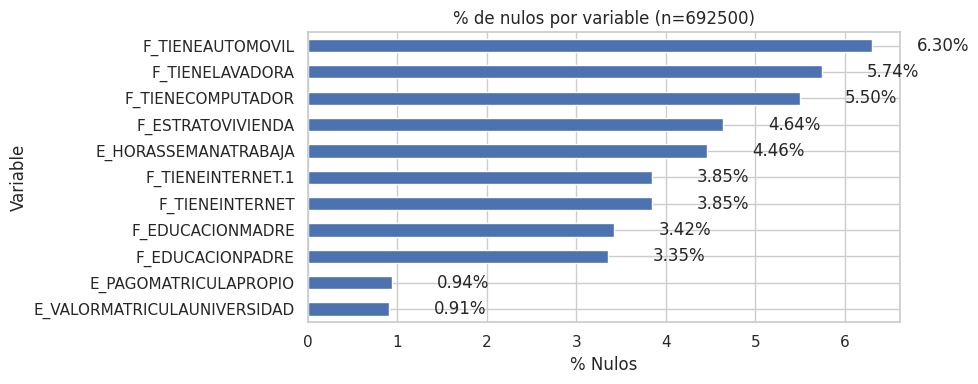

In [ ]:
def plot_missing(df, kind="bar", top_n=None, title=None):
    """
    Visualiza el porcentaje de nulos por columna.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame de entrada
    kind : {"bar", "pie"}
        Tipo de gráfico a dibujar.
    top_n : int | None
        Si se indica, muestra solo las N variables con mayor % de nulos.
    title : str | None
        Título del gráfico.
    """
    # Cálculo de nulos y % nulos
    total_rows = len(df)
    null_counts = df.isna().sum()
    pct_nulls = (null_counts / total_rows * 100).round(2)

    # Filtrar columnas con nulos
    has_nulls = pct_nulls[pct_nulls > 0]
    if has_nulls.empty:
        print("No hay columnas con valores nulos")
        return

    # Ordenar de mayor a menor
    has_nulls = has_nulls.sort_values(ascending=False)

    # Top N opcional
    if isinstance(top_n, int) and top_n > 0:
        has_nulls = has_nulls.head(top_n)

    # Título por defecto
    if title is None:
        title = f"% de nulos por variable (n={total_rows})"

    # --- Gráficos ---
    if kind == "bar":
        plt.figure(figsize=(10, max(4, 0.35*len(has_nulls))))
        # barras horizontales para que se lea bien el nombre de la variable
        ax = has_nulls.plot(kind="barh")
        ax.invert_yaxis()  # mayor % arriba
        ax.set_xlabel("% Nulos")
        ax.set_ylabel("Variable")
        ax.set_title(title)
        # Anotar valores al final de cada barra
        for i, v in enumerate(has_nulls.values):
            ax.text(v + 0.5, i, f"{v:.2f}%", va="center")
        plt.tight_layout()
        plt.show()

    elif kind == "pie":
        # La torta se entiende mejor si no hay demasiadas categorías
        # (se puede forzar con top_n o limitar automáticamente)
        data = has_nulls.copy()
        max_slices = 12
        if len(data) > max_slices:
            # agrupar el resto como "Otros"
            main = data.head(max_slices - 1)
            otros = pd.Series({"Otros": data.iloc[max_slices - 1 :].sum()})
            data = pd.concat([main, otros])

        plt.figure(figsize=(8, 8))
        plt.pie(
            data.values,
            labels=data.index,
            autopct=lambda p: f"{p:.1f}%",
            startangle=90,
            counterclock=False
        )
        plt.title(title)
        plt.tight_layout()
        plt.show()

    else:
        raise ValueError("kind debe ser 'bar' o 'pie'.")

# Barras (todas las variables con nulos)
plot_missing(train, kind="bar")


In [ ]:
sns.set_theme(style="whitegrid", context="notebook")
def figures_grid(nrows, ncols, funcs, figsize=(20, 4),
                 dpi=120, style='whitegrid',
                 wspace=0.30, hspace=0.40,
                 title=None):
    """
    Mantiene la firma: figures_grid(3,1,[f1,f2,f3], figsize=(20,3))
    y, si recibe (3,1), lo muestra como 1x3 para que cada variable
    tenga tres paneles en una sola fila.
    """
    sns.set_theme(style=style)
    sns.set_context('notebook')

    # reinterpretar 3x1 como 1x3
    if nrows == 3 and ncols == 1:
        nrows_plot, ncols_plot = 1, 3
    else:
        nrows_plot, ncols_plot = nrows, ncols

    fig, axes = plt.subplots(nrows_plot, ncols_plot, figsize=figsize, dpi=dpi)

    # asegurar lista de ejes
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = np.ravel(axes).tolist()

    # ejecutar funciones
    for ax, func in zip_longest(axes, funcs):
        if ax is None:
            continue
        if func is None:
            ax.axis('off')
            continue
        plt.sca(ax)
        func()
        ax.grid(True, alpha=0.25)

        # rotar etiquetas si hay muchas categorías
        xticks = ax.get_xticklabels()
        if len(xticks) > 6:
            for t in xticks:
                t.set_rotation(30)
                t.set_horizontalalignment('right')

    # limpiar leyendas en ejes intermedios
    for ax in axes[:-1]:
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()

    # mover leyenda del último eje fuera del gráfico
    if len(axes) > 0 and axes[-1].get_legend() is not None:
        axes[-1].legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
                        frameon=True, borderaxespad=0.)

    plt.tight_layout()
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    if title:
        fig.suptitle(title, y=1.02, fontsize=14)
        plt.tight_layout()

    plt.show()
    return fig, axes


In [ ]:
def plot_missing(col, target):

    def f1():
        if d[col].dtype == object:
            k = d[col].fillna("missing").value_counts()
            sns.barplot(x=k.index, y=k.values)
        else:
            plt.hist(d[col].dropna().values, bins=100)
        plt.title("distribution of %s" % col)
        plt.grid()

    def f2():
        # Si col es categórica: comparar la distribución del target por categoría
        if d[col].dtype == object:
            k_local = d[[col, target]].dropna()
            # ¿target es numérico o categórico?
            target_is_num = is_numeric_dtype(k_local[target])

            for v in d[col].dropna().unique():
                if sum(k_local[col] == v) > 1:
                    if target_is_num:
                        # target continuo → hist con KDE
                        sns.histplot(
                            k_local[target][k_local[col] == v],
                            kde=True, stat='density', alpha=.3, label=v
                        )
                    else:
                        # target categórico → barras discretas SIN KDE
                        sns.histplot(
                            k_local[target][k_local[col] == v],
                            discrete=True, stat='probability',
                            multiple='dodge', shrink=0.8, alpha=.6, label=v
                        )

            # valores faltantes en col
            if sum(d[col].isna()) > 1:
                if target_is_num:
                    sns.histplot(
                        d[target][d[col].isna()],
                        alpha=.8, kde=True, stat='density', label="missing"
                    )
                else:
                    sns.histplot(
                        d[target][d[col].isna()],
                        discrete=True, stat='probability',
                        multiple='dodge', shrink=0.8,
                        alpha=.8, label="missing"
                    )
            plt.legend()
        else:
            # col numérica: scatter contra target
            plt.scatter(d[col], d[target], alpha=.5)
            plt.xlabel(target)
            plt.ylabel(col)
        plt.grid()
        plt.title("%s vs target" % (col))

    def f3():
        n = np.sum(d[col].isna())
        target_is_num = is_numeric_dtype(d[target])

        if target_is_num:
            # target continuo: curvas sin relleno
            if n > 1:
                sns.histplot(
                    d[target][d[col].isna()],
                    color="red", kde=True, alpha=.3, label="missing (%d values)" % n,
                    stat='density'
                )
            sns.histplot(
                d[target][~d[col].isna()],
                color="blue", kde=True, alpha=.3, label="ok (%d values)" % (len(d) - n),
                stat='density'
            )
        else:
            # target categórico: barras discretas sin KDE
            if n > 1:
                sns.histplot(
                    d[target][d[col].isna()],
                    discrete=True, stat='count',
                    element='step', fill=False,
                    color="red", alpha=.7, label="missing (%d values)" % n
                )
            sns.histplot(
                d[target][~d[col].isna()],
                discrete=True, stat='count',
                element='step', fill=False,
                color="blue", alpha=.7, label="ok (%d values)" % (len(d) - n)
            )

        plt.title("distribution of target wrt %s" % col)
        plt.yticks([])
        plt.grid()
        plt.legend()

    figures_grid(3, 1, [f1, f2, f3], figsize=(20, 3))

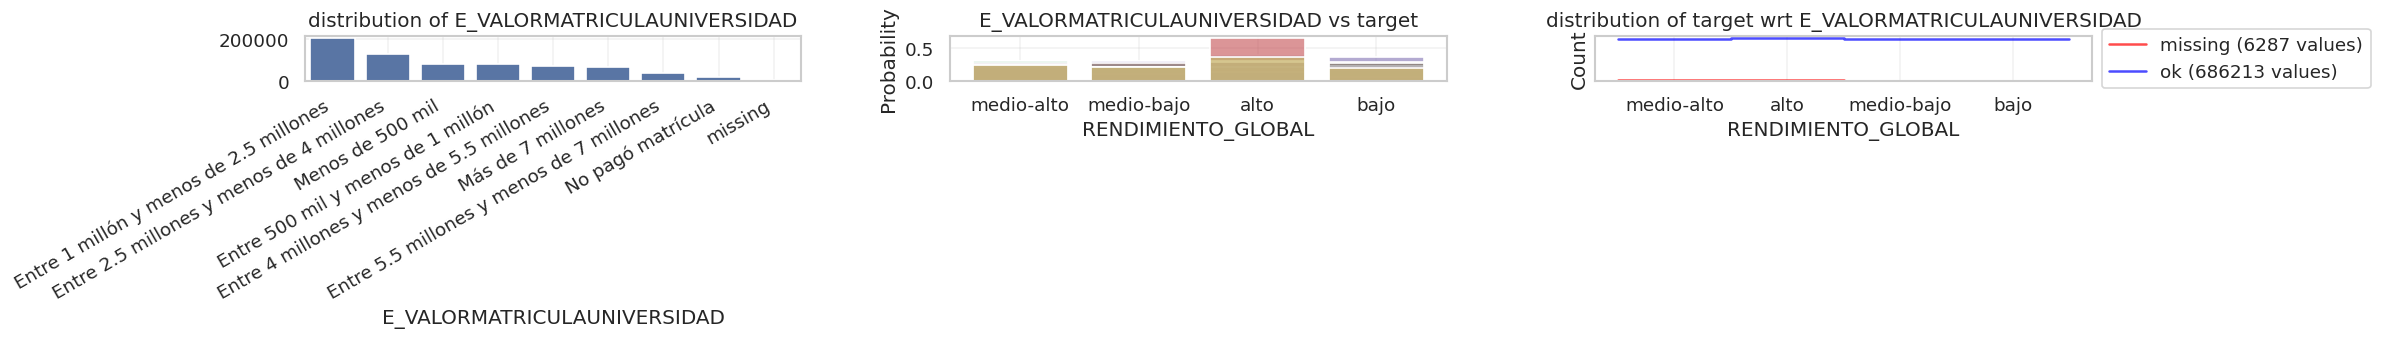

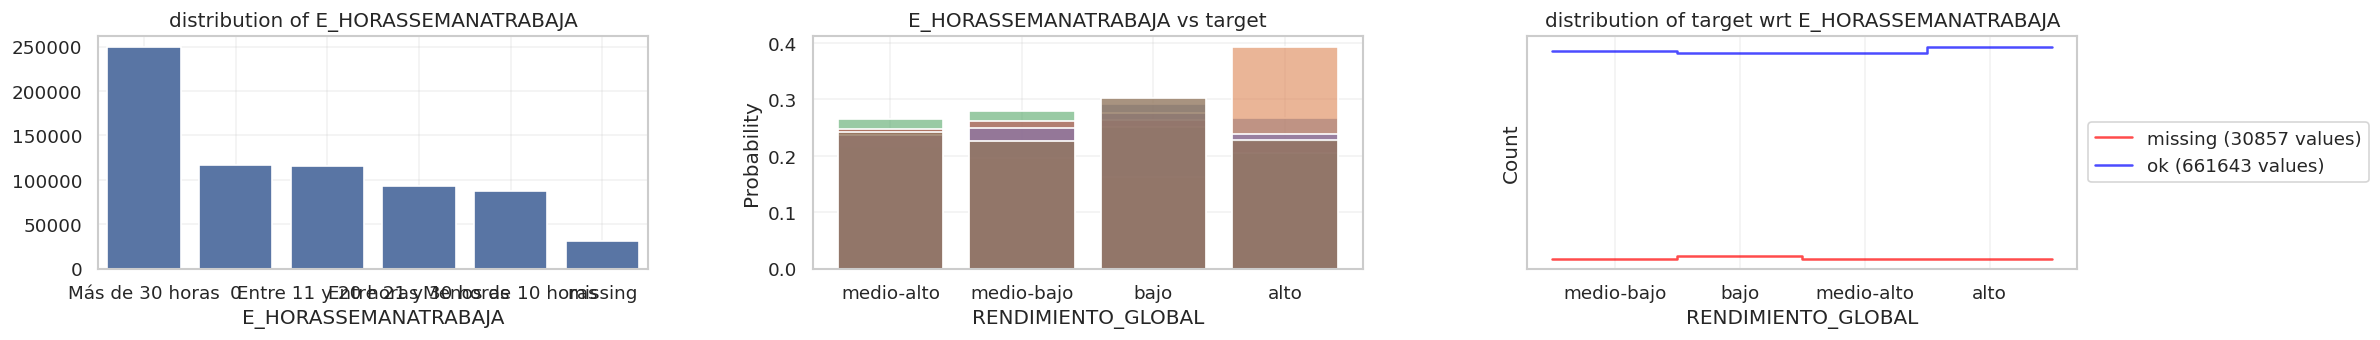

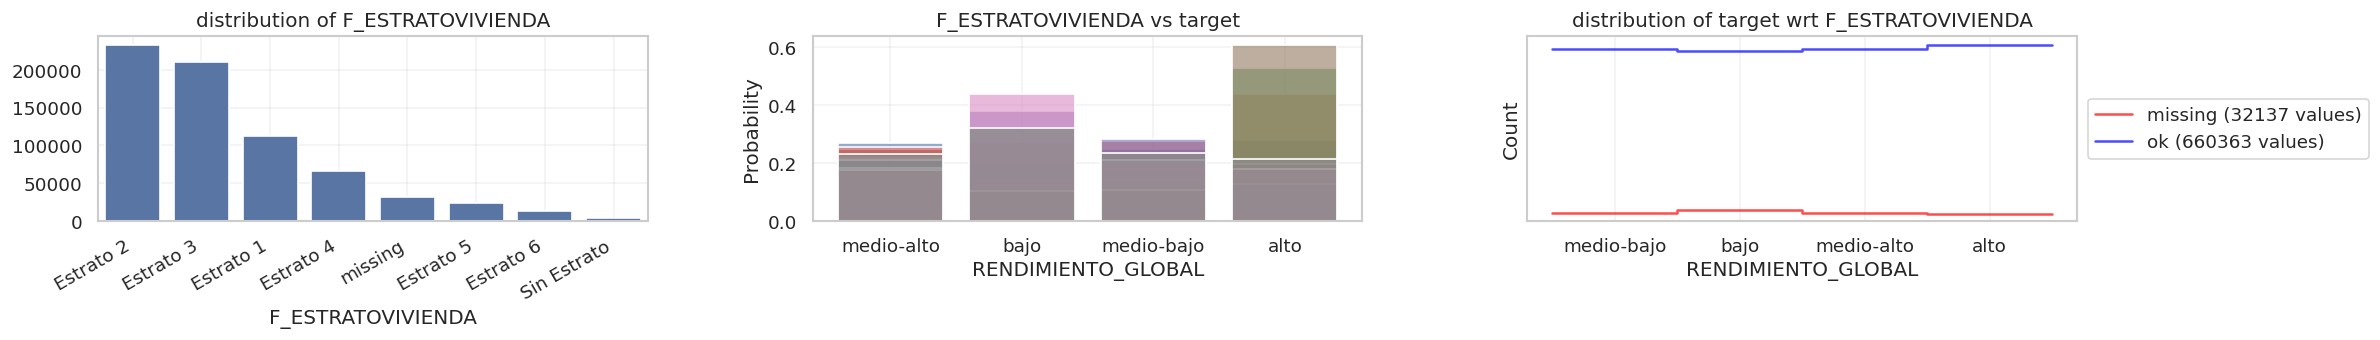

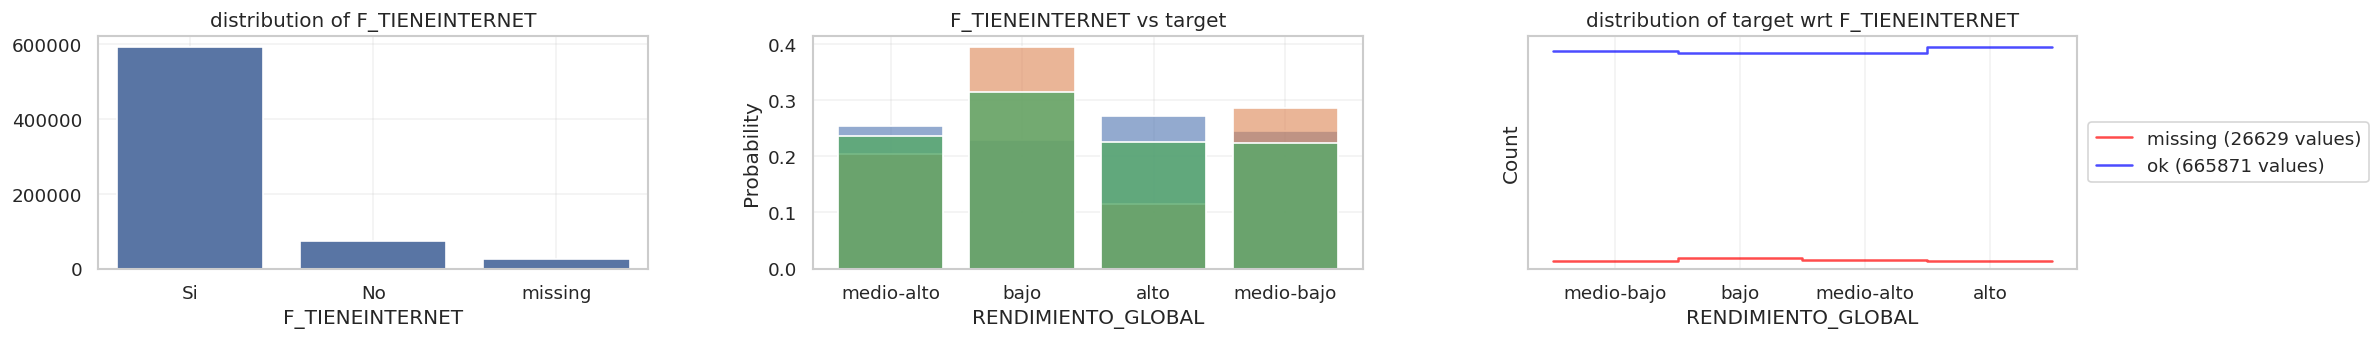

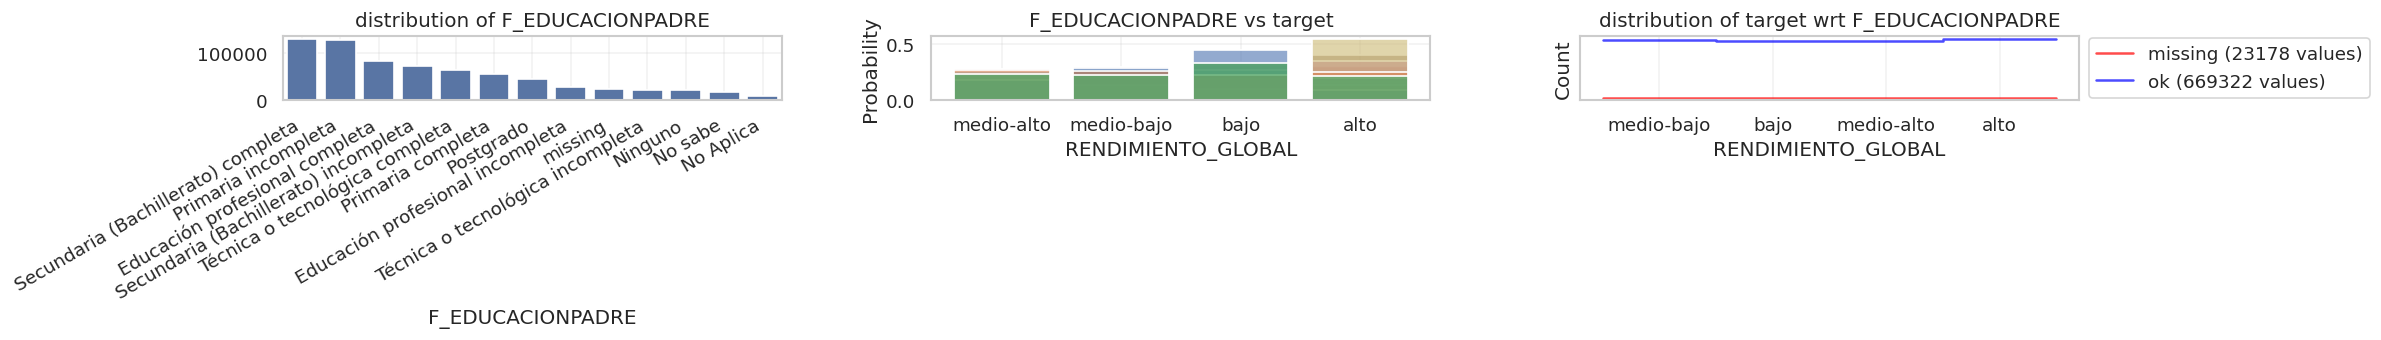

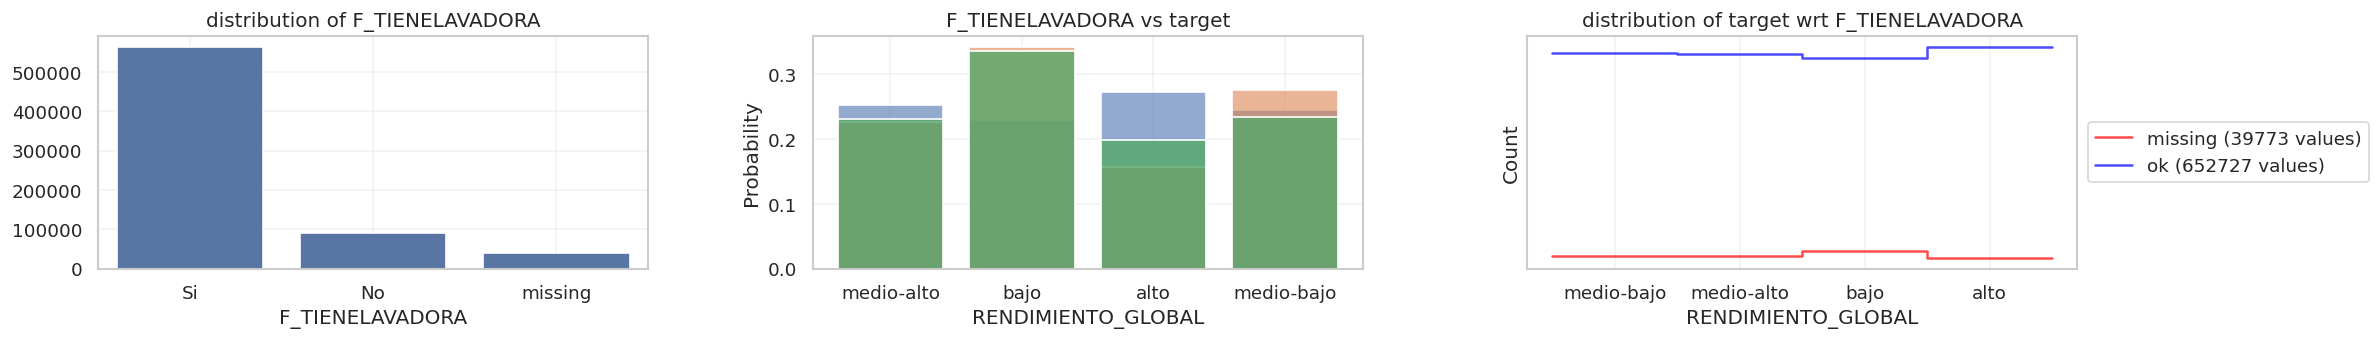

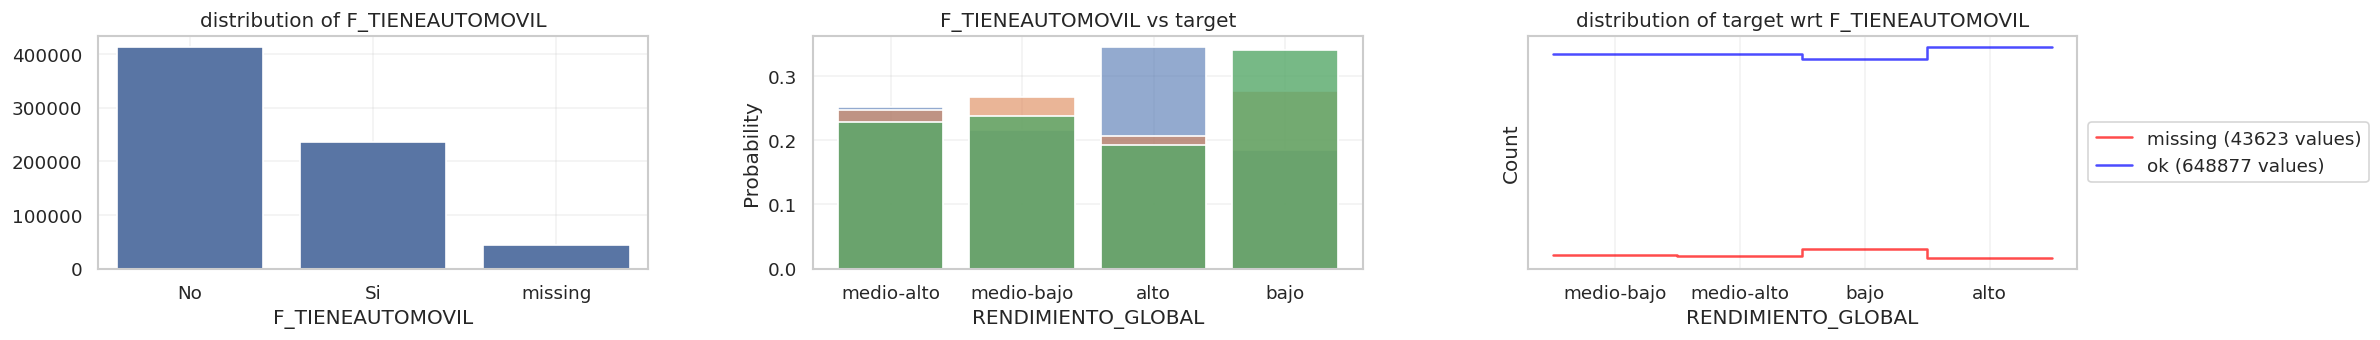

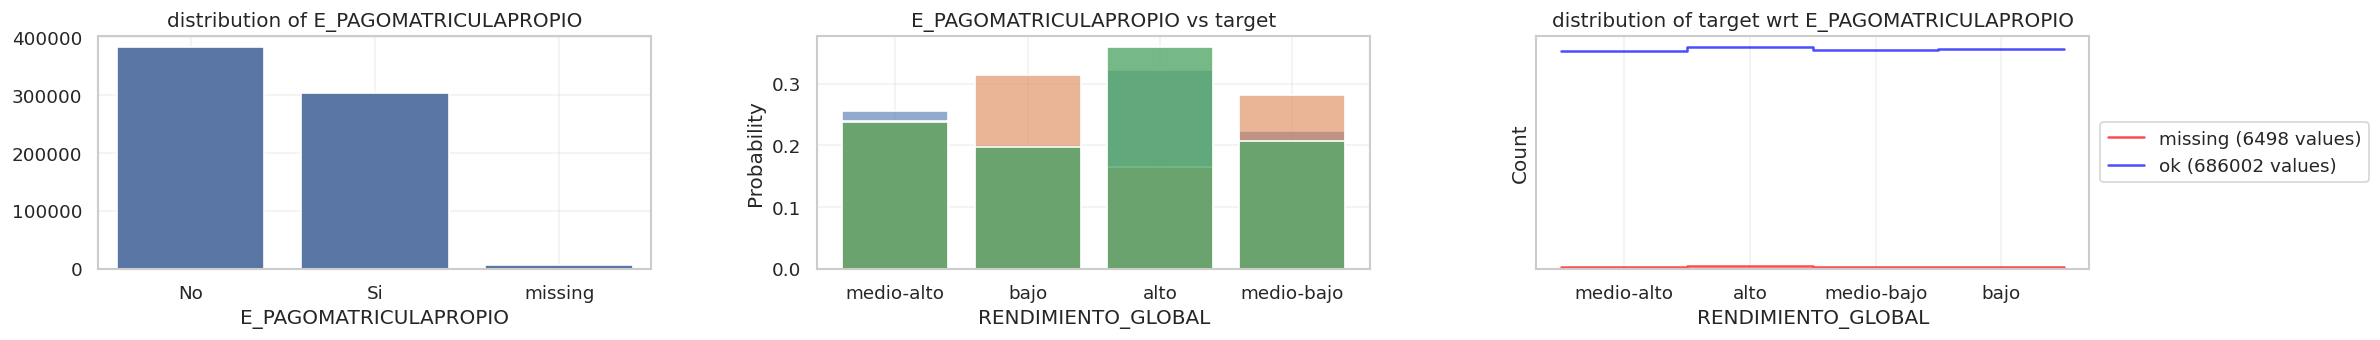

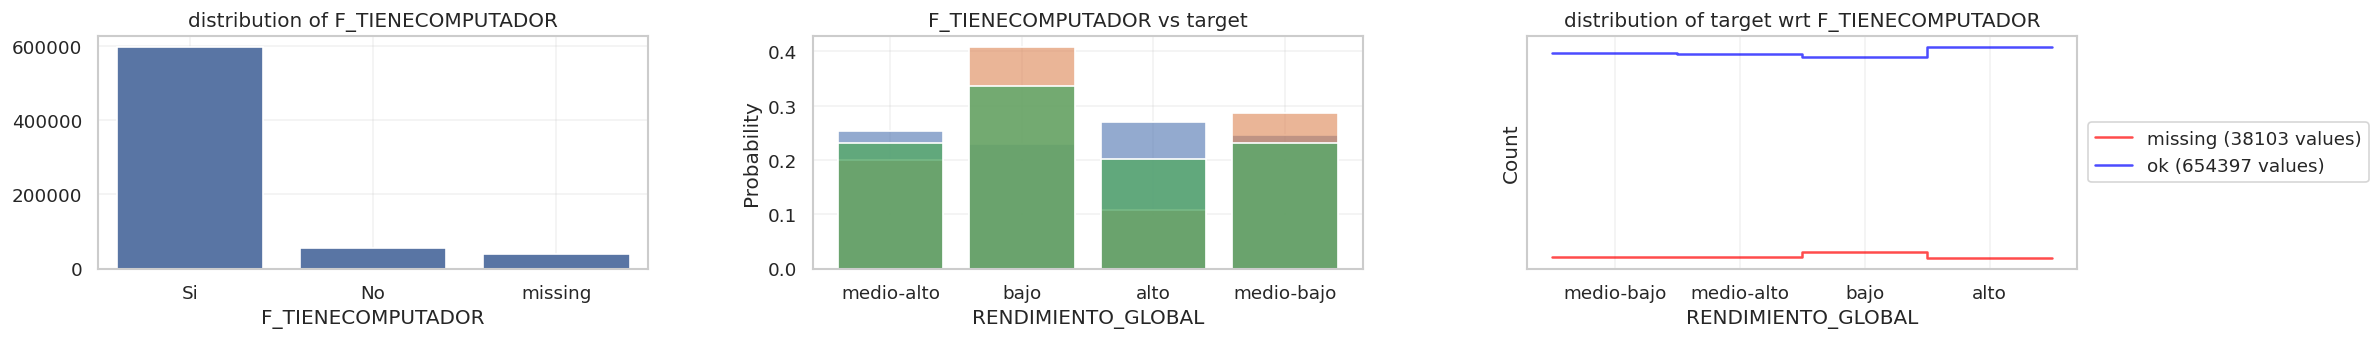

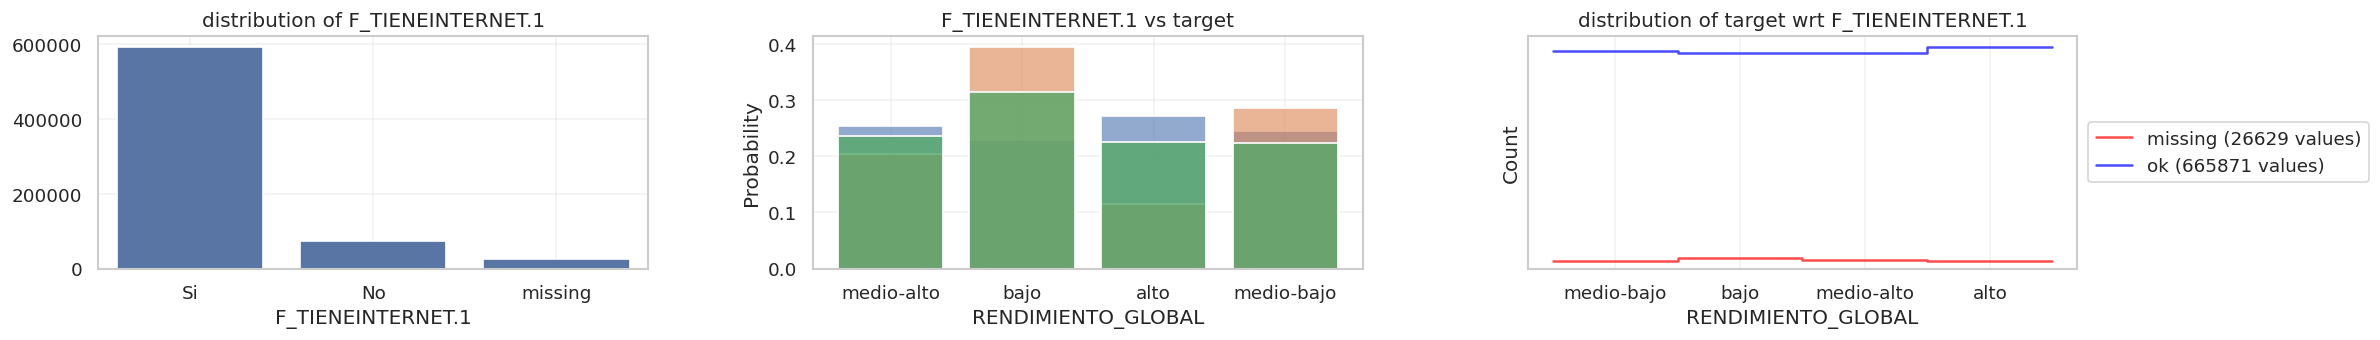

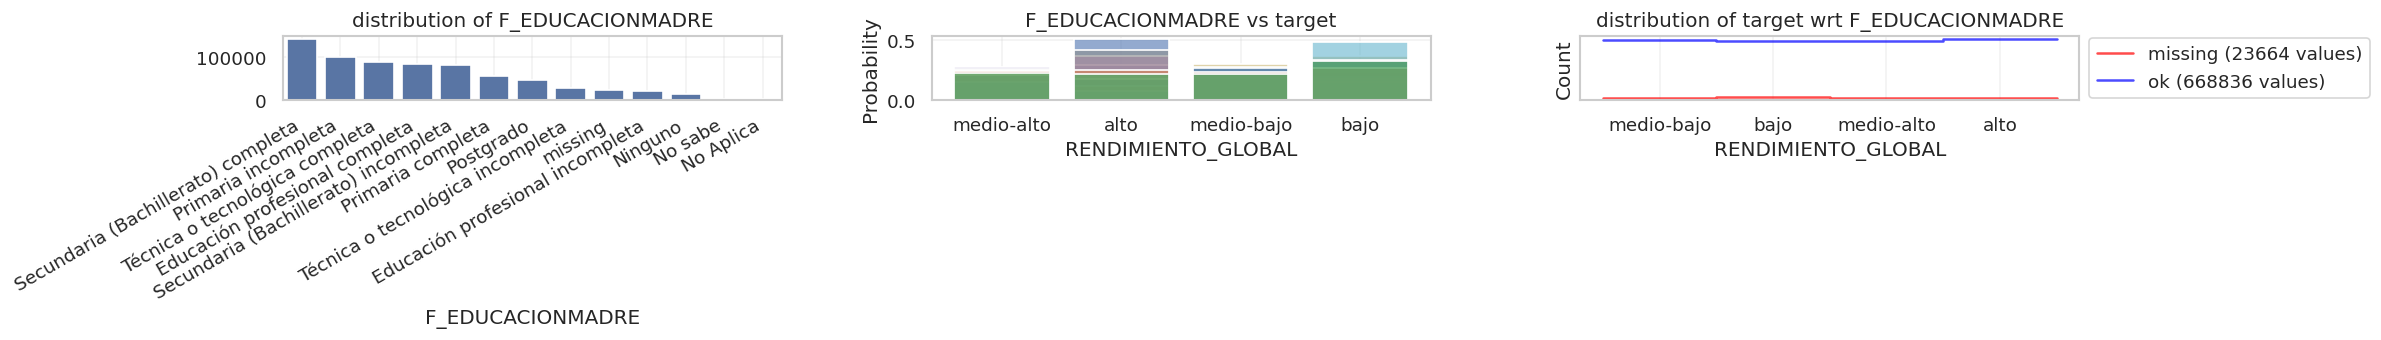

In [ ]:
d = train.copy()
k = d.isna().sum()
for col in k[k != 0].index:
    plot_missing(col, target="RENDIMIENTO_GLOBAL")



*   Los datos no presentan problemas severos de completitud; los porcentajes de la información faltante es baja (<7%).
*   Dado que las variables donde hace falta informacion son categóricas, la estrategia que vamos a seguir es imputar los nulos con la categoría más frecuente (moda) con el fin de conservar la distribución original de las categorías.
*   Para el resto de variables nominales realizaremos una conversión con one-hot
*   Hacemos un mapeo para las variables ordinales y binarias por valores numéricos positivos









In [ ]:
def imputar_moda(df: pd.DataFrame, mostrar_resumen: bool = True) -> pd.DataFrame:
    """
    Detecta automáticamente las columnas con valores faltantes y,
    si son categóricas, imputa los valores nulos con la categoría más frecuente (moda).

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame original con posibles valores faltantes.
    mostrar_resumen : bool, opcional
        Si True, imprime un resumen antes y después de la imputación.

    Retorna
    -------
    pd.DataFrame
        Copia del DataFrame con los valores imputados (solo categóricas).
    """

    # Crear una copia del DataFrame original (no se modifica el original)
    df_proc = df.copy()

    # Normaliza los falsos nulos (texto)
    df_proc = df_proc.replace(['nan', 'NaN', 'None', '', ' '], pd.NA)

    # Detectar columnas con valores faltantes
    columnas_con_nulos = df_proc.columns[df_proc.isna().any()].tolist()

    # Filtrar solo las categóricas
    columnas_categoricas = [
        col for col in columnas_con_nulos
        if df_proc[col].dtype == 'object' or str(df_proc[col].dtype) == 'category'
    ]

    if not columnas_categoricas:
        print("No se encontraron columnas categóricas con valores faltantes.")
        return df_proc

    if mostrar_resumen:
        resumen_antes = df_proc[columnas_categoricas].isna().sum().to_frame(name="Nulos antes")
        #print("Resumen de valores faltantes antes de imputar:\n")
        #display(resumen_antes)

    print("\nIniciando imputación automática por moda en columnas categóricas:\n")

    for col in columnas_categoricas:
        nulos_antes = df_proc[col].isna().sum()
        if nulos_antes > 0:
            moda = df_proc[col].mode(dropna=True)
            if len(moda) > 0:
                valor_moda = moda[0]
                df_proc[col] = df_proc[col].fillna(valor_moda)
                print(f"'{col}': {nulos_antes} valores imputados con la moda → '{valor_moda}'")
            else:
                print(f"'{col}' no tiene moda disponible (columna vacía o todos nulos).")
        else:
            print(f"'{col}' no tiene valores faltantes.")

    # Resumen después
    if mostrar_resumen:
        resumen_despues = df_proc[columnas_categoricas].isna().sum().to_frame(name="Nulos después")
        resumen = resumen_antes.join(resumen_despues)
        print("\nComparativo antes y después de imputar:\n")
        display(resumen)

    print("\nImputación finalizada.\n")
    return df_proc

In [ ]:
d = imputar_moda(d,mostrar_resumen= True)


Iniciando imputación automática por moda en columnas categóricas:

'E_VALORMATRICULAUNIVERSIDAD': 6287 valores imputados con la moda → 'Entre 1 millón y menos de 2.5 millones'
'E_HORASSEMANATRABAJA': 30857 valores imputados con la moda → 'Más de 30 horas'
'F_ESTRATOVIVIENDA': 32137 valores imputados con la moda → 'Estrato 2'
'F_TIENEINTERNET': 26629 valores imputados con la moda → 'Si'
'F_EDUCACIONPADRE': 23178 valores imputados con la moda → 'Secundaria (Bachillerato) completa'
'F_TIENELAVADORA': 39773 valores imputados con la moda → 'Si'
'F_TIENEAUTOMOVIL': 43623 valores imputados con la moda → 'No'
'E_PAGOMATRICULAPROPIO': 6498 valores imputados con la moda → 'No'
'F_TIENECOMPUTADOR': 38103 valores imputados con la moda → 'Si'
'F_TIENEINTERNET.1': 26629 valores imputados con la moda → 'Si'
'F_EDUCACIONMADRE': 23664 valores imputados con la moda → 'Secundaria (Bachillerato) completa'

Comparativo antes y después de imputar:



,Nulos antes,Nulos después
E_VALORMATRICULAUNIVERSIDAD,6287,0
E_HORASSEMANATRABAJA,30857,0
F_ESTRATOVIVIENDA,32137,0
F_TIENEINTERNET,26629,0
F_EDUCACIONPADRE,23178,0
F_TIENELAVADORA,39773,0
F_TIENEAUTOMOVIL,43623,0
E_PAGOMATRICULAPROPIO,6498,0
F_TIENECOMPUTADOR,38103,0
F_TIENEINTERNET.1,26629,0



Imputación finalizada.



In [ ]:
#Verificamos nuevamente después de la imputación si hay valores faltantes

resumen_nulos = resumen_valores_faltantes(d)

,Variable,Tipo de Dato,Valores Únicos,# No Nulos,# Nulos,% Nulos


In [ ]:
def mapear(df: pd.DataFrame) -> pd.DataFrame:
    df_mapeado = df.copy()

    # Ordinales
    mapeo_estrato = {'Sin Estrato': 0, 'Estrato 1': 1, 'Estrato 2': 2, 'Estrato 3': 3,
                     'Estrato 4': 4, 'Estrato 5': 5, 'Estrato 6': 6}

    mapeo_horas = {'0': 0, 'Menos de 10 horas': 1, 'Entre 11 y 20 horas': 2,
                   'Entre 21 y 30 horas': 3, 'Más de 30 horas': 4}

    mapeo_educacion = {'No Aplica': 0, 'No sabe': 0, 'Ninguno': 0, 'Primaria incompleta': 1,
                       'Primaria completa': 2, 'Secundaria (Bachillerato) incompleta': 3,
                       'Secundaria (Bachillerato) completa': 4, 'Técnica o tecnológica incompleta': 5,
                       'Técnica o tecnológica completa': 6, 'Educación profesional incompleta': 7,
                       'Educación profesional completa': 8, 'Postgrado': 9}

    mapeo_matricula = {'No pagó matrícula': 0, 'Menos de 500 mil': 1,
                       'Entre 500 mil y menos de 1 millón': 2,
                       'Entre 1 millón y menos de 2.5 millones': 3,
                       'Entre 2.5 millones y menos de 4 millones': 4,
                       'Entre 4 millones y menos de 5.5 millones': 5,
                       'Entre 5.5 millones y menos de 7 millones': 6,
                       'Más de 7 millones': 7}

    mapeo_redimiento = {
    'bajo': 0,
    'medio-bajo': 1,
    'medio-alto': 2,
    'alto': 3
    }

    # Binarias
    binaria ={
        'Si': 1,
        'No': 0,
        'N':0,
        'S':1
    }

    # Aplicar todos los mapeos
    df_mapeado['F_ESTRATOVIVIENDA'] = df_mapeado['F_ESTRATOVIVIENDA'].map(mapeo_estrato)
    df_mapeado['E_HORASSEMANATRABAJA'] = df_mapeado['E_HORASSEMANATRABAJA'].map(mapeo_horas)
    df_mapeado['F_EDUCACIONMADRE'] = df_mapeado['F_EDUCACIONMADRE'].map(mapeo_educacion)
    df_mapeado['F_EDUCACIONPADRE'] = df_mapeado['F_EDUCACIONPADRE'].map(mapeo_educacion)
    df_mapeado['E_VALORMATRICULAUNIVERSIDAD'] = df_mapeado['E_VALORMATRICULAUNIVERSIDAD'].map(mapeo_matricula)
    df_mapeado['RENDIMIENTO_GLOBAL'] = df_mapeado['RENDIMIENTO_GLOBAL'].map(mapeo_redimiento)

    # Codificación para variables binarias
    columnas_binarias = [
        'F_TIENEAUTOMOVIL', 'F_TIENELAVADORA', 'F_TIENECOMPUTADOR',
        'F_TIENEINTERNET.1', 'F_TIENEINTERNET', 'E_PAGOMATRICULAPROPIO',
        'E_PRIVADO_LIBERTAD'
    ]
    for col in columnas_binarias:
        if col in df_mapeado.columns:
            df_mapeado[col] = df_mapeado[col].map(binaria)
            # Asegurar que la columna sea de tipo numérico después del mapeo
            df_mapeado[col] = pd.to_numeric(df_mapeado[col], errors='coerce')

    return df_mapeado


In [ ]:
d = mapear(d)

In [ ]:
resumen_unicos = resumen_valores_unicos(d)

,Valores únicos,Número de valores únicos
ID,"[904256, 645256, 308367, 470353, 989032, 65987...",692500
PERIODO_ACADEMICO,"[20212, 20203, 20195, 20183, 20194, 20213, 201...",9
E_PRGM_ACADEMICO,"[ENFERMERIA, DERECHO, MERCADEO Y PUBLICIDAD, A...",948
E_PRGM_DEPARTAMENTO,"[BOGOTÁ, ATLANTICO, SANTANDER, ANTIOQUIA, HUIL...",31
E_VALORMATRICULAUNIVERSIDAD,"[6, 4, 5, 7, 3, 2, 1, 0]",8
E_HORASSEMANATRABAJA,"[1, 0, 4, 3, 2]",5
F_ESTRATOVIVIENDA,"[3, 4, 5, 2, 1, 6, 0]",7
F_TIENEINTERNET,"[1, 0]",2
F_EDUCACIONPADRE,"[5, 6, 4, 0, 2, 8, 7, 1, 9, 3]",10
F_TIENELAVADORA,"[1, 0]",2


In [ ]:
# Eliminamos la columna ID del df ya que no aporta al análisis
d = d.drop(columns=['ID'])

##**6. CORRELACIÓN DE VARIABLES**

In [ ]:
def graficar_matriz_correlacion(df: pd.DataFrame,
                                metodo: str = "pearson",
                                excluir: list = ["ID"],
                                titulo: str = None,
                                anotar: bool = True) -> pd.DataFrame:
    """
    Calcula y grafica la matriz de correlación de las columnas numéricas de un DataFrame.

    Parámetros
    ----------
    df : pd.DataFrame
        Conjunto de datos ya mapeado o codificado numéricamente.
    metodo : {'pearson','spearman','kendall'}
        Tipo de correlación a usar.
    excluir : list
        Columnas a excluir (por ejemplo identificadores).
    titulo : str
        Título del gráfico.
    anotar : bool
        Si True muestra valores sobre el mapa (solo recomendable si hay pocas columnas).

    Retorna
    -------
    pd.DataFrame
        Matriz de correlación calculada.
    """
    # columnas numéricas
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in excluir]

    if len(num_cols) < 2:
        print("No hay suficientes columnas numéricas para correlación.")
        return pd.DataFrame()

    # matriz de correlación
    corr = df[num_cols].corr(method=metodo).round(2)

    # tamaño de la figura
    n = len(num_cols)
    figsize = (min(1.0 * n, 20), min(0.8 * n, 20))
    plt.figure(figsize=figsize)

    # máscara para ocultar triángulo superior
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

    # mapa de calor
    sns.heatmap(corr,
                vmin=-1, vmax=1,
                annot=(anotar and n <= 25),
                fmt=".2f",
                cmap="BrBG",
                mask=mask,
                square=True,
                cbar_kws={"shrink": .8})

    plt.title(titulo or f"Matriz de correlación ({metodo.capitalize()})", y=1.02, fontsize=13)
    plt.tight_layout()
    plt.show()

    return corr

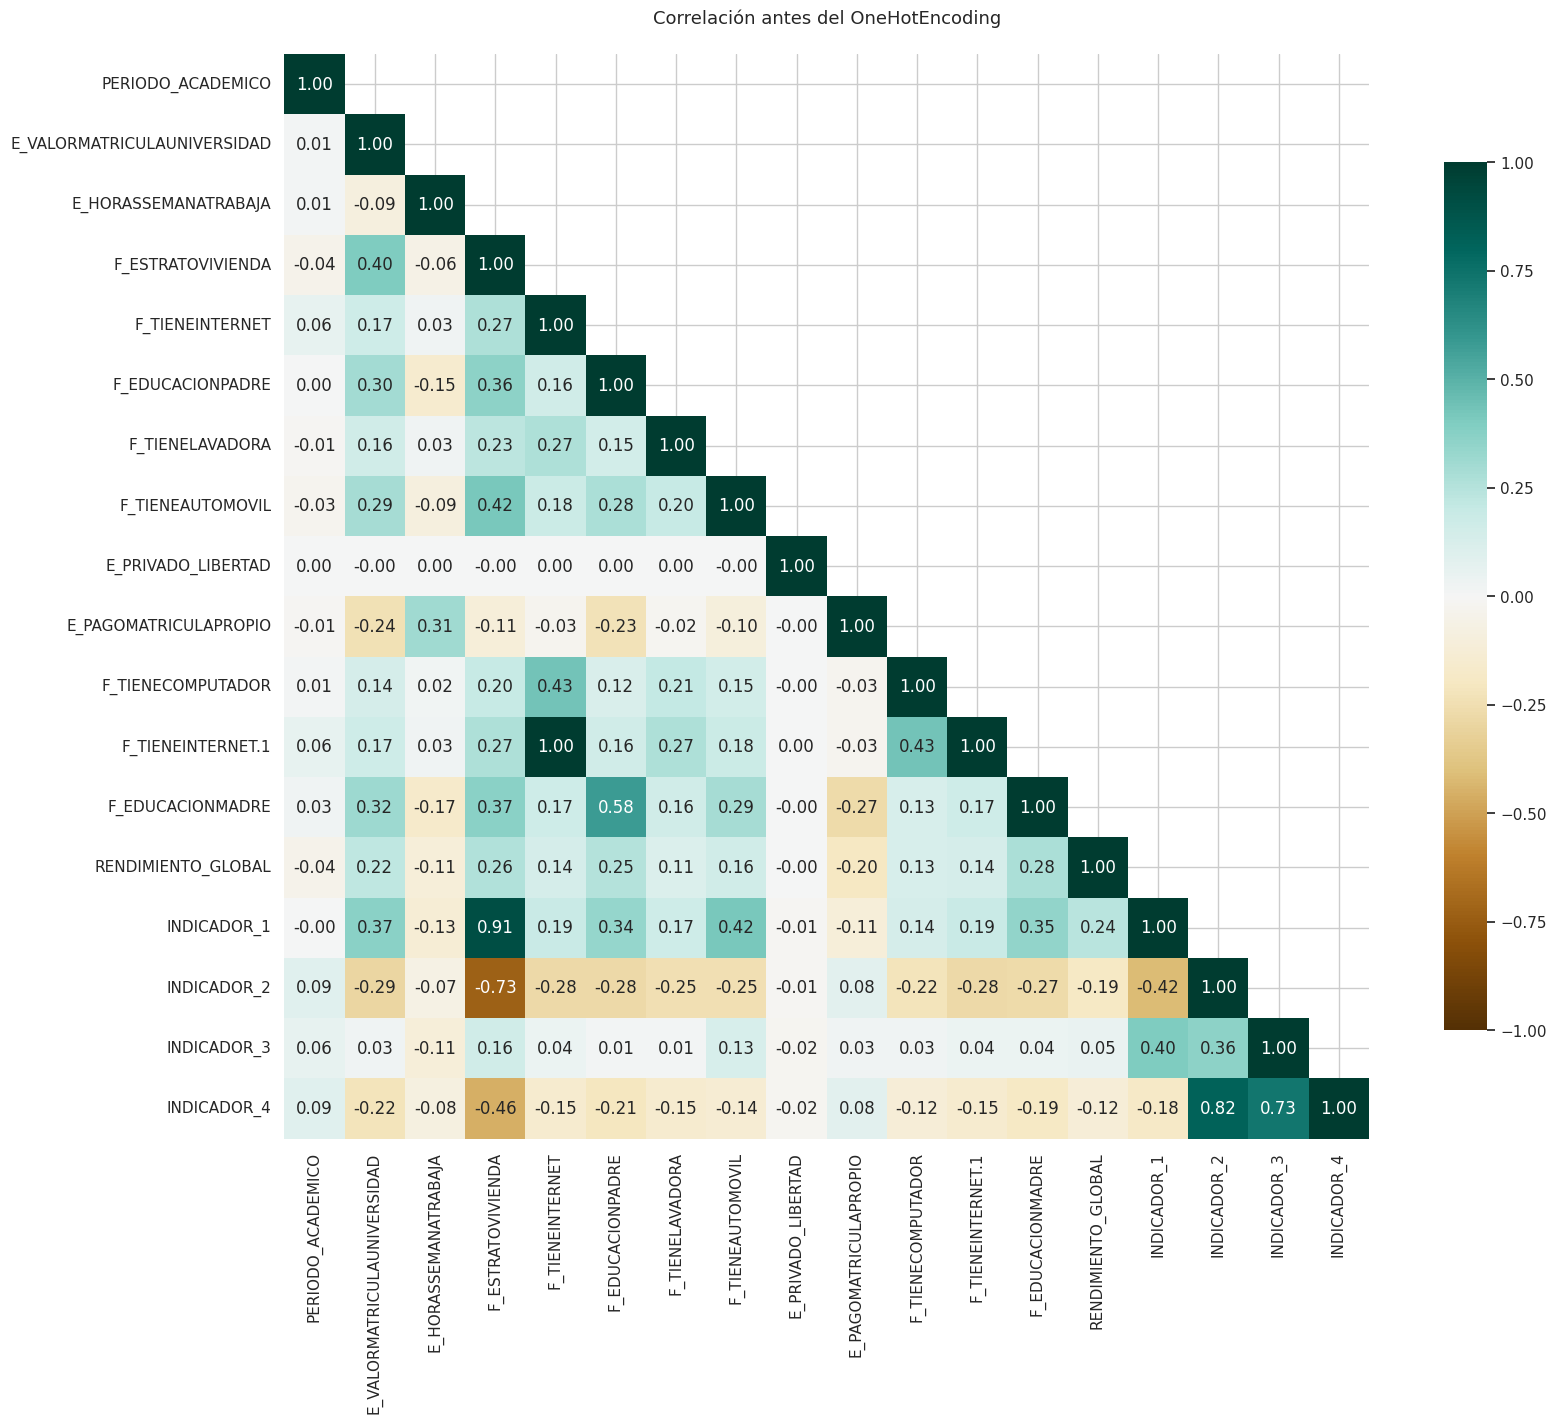

In [ ]:
corr_before = graficar_matriz_correlacion(d,
                                          metodo='pearson',
                                          titulo="Correlación antes del OneHotEncoding")

Decidimos eliminar las variables que tienen alta correlación

In [ ]:
def eliminar_col_correlacionadas(df: pd.DataFrame,
                                 metodo: str = 'pearson',
                                 umbral: float = 0.9,
                                 mostrar: bool = True,
                                 excluir: list | None = None,
                                 incluir_bool: bool = False) -> pd.DataFrame:
    """
    Elimina columnas numéricas altamente correlacionadas (redundantes) de un DataFrame,
    ignorando automáticamente las columnas categóricas/objetos.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame original.
    metodo : {'pearson','spearman','kendall'}
        Método de correlación.
    umbral : float
        Valor absoluto mínimo de correlación considerado "altísimo". Default = 0.9.
    mostrar : bool
        Si True, imprime resumen de columnas evaluadas y eliminadas.
    excluir : list | None
        Lista de columnas a excluir del análisis (p. ej. ['ID']).
    incluir_bool : bool
        Si True, incluye columnas booleanas en el análisis (por defecto se excluyen).

    Retorna
    -------
    pd.DataFrame
        Nuevo DataFrame sin las columnas numéricas altamente correlacionadas.
    """

    df_proc = df.copy()

    # 1) Seleccionar SOLO columnas numéricas (ignora categóricas automáticamente)
    num_cols = df_proc.select_dtypes(include=[np.number]).columns.tolist()

    # Opcional: excluir booleanas si no se desean en Pearson
    if not incluir_bool:
        bool_cols = df_proc.select_dtypes(include=['bool']).columns.tolist()
        num_cols = [c for c in num_cols if c not in bool_cols]

    # Excluir columnas indicadas por el usuario (p. ej., ID)
    if excluir:
        num_cols = [c for c in num_cols if c not in excluir]

    if len(num_cols) < 2:
        if mostrar:
            print("No hay suficientes columnas numéricas para evaluar correlación después de los filtros.")
            print(f"Columnas numéricas consideradas: {num_cols}")
        return df_proc

    # 2) Matriz de correlación ABSOLUTA solo sobre numéricas
    corr_matrix = df_proc[num_cols].corr(method=metodo, numeric_only=True).abs()

    # 3) Triángulo superior para no duplicar parejas
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 4) Identificar columnas a eliminar (si alguna correlación supera el umbral)
    col_eliminar = [col for col in upper.columns if any(upper[col] > umbral)]

    # 5) Eliminar solo esas columnas del DataFrame (las no numéricas se mantienen intactas)
    df_reducido = df_proc.drop(columns=col_eliminar, errors='ignore')

    if mostrar:
        print(f"Columnas numéricas consideradas ({len(num_cols)}): {num_cols}")
        if col_eliminar:
            print(f"\nColumnas eliminadas por correlación > {umbral} ({metodo}):")
            for c in col_eliminar:
                correladas = upper.index[upper[c] > umbral].tolist()
                print(f"  - {c} correlacionada con {correladas}")
        else:
            print(f"\nNo se encontraron columnas con correlación > {umbral} ({metodo}).")

        print(f"\nForma original: {df.shape}")
        print(f"Forma reducida: {df_reducido.shape}")

    return df_reducido

In [ ]:
d = eliminar_col_correlacionadas(
    d, metodo='pearson', umbral=0.9, mostrar=True, excluir=['ID'], incluir_bool=False
)

Columnas numéricas consideradas (18): ['PERIODO_ACADEMICO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']

Columnas eliminadas por correlación > 0.9 (pearson):
  - F_TIENEINTERNET.1 correlacionada con ['F_TIENEINTERNET']
  - INDICADOR_1 correlacionada con ['F_ESTRATOVIVIENDA']

Forma original: (692500, 20)
Forma reducida: (692500, 18)


##**7. SEPARACIÓN DE TRAIN EN X,y**

In [ ]:
def separar_X_y(df: pd.DataFrame, target: str = "RENDIMIENTO_GLOBAL", drop_cols: list | None = None, mostrar_info: bool = True):
    """
    Separa un DataFrame en variables predictoras (X) y variable objetivo (y),
    detectando el target sin distinguir mayúsculas/minúsculas.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame completo con predictores y la variable objetivo.
    target : str, opcional
        Nombre de la columna objetivo (no sensible a mayúsculas/minúsculas).
    drop_cols : list | None, opcional
        Lista de columnas adicionales a eliminar de X (por ejemplo: ['ID']).
    mostrar_info : bool, opcional
        Si True, imprime información del resultado.

    Retorna
    -------
    tuple
        (X, y) donde:
        - X es un DataFrame con las variables predictoras.
        - y es una Serie con la variable objetivo.
    """

    # Validar DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError("El argumento 'df' debe ser un DataFrame de pandas.")

    # Normalizar nombres de columnas a minúsculas para búsqueda
    columnas_norm = {col.lower(): col for col in df.columns}
    target_lower = target.lower()

    # Intentar encontrar el target (case-insensitive)
    if target_lower in columnas_norm:
        col_target_real = columnas_norm[target_lower]
    else:
        raise ValueError(f"No se encontró una columna equivalente a '{target}'. "
                         f"Columnas disponibles: {list(df.columns)}")

    # Crear copias seguras
    X = df.copy()
    y = X.pop(col_target_real)

    # Eliminar columnas adicionales si se especifican
    if drop_cols:
        cols_existentes = [c for c in drop_cols if c in X.columns]
        X = X.drop(columns=cols_existentes, errors='ignore')
        if mostrar_info:
            print(f"Columnas eliminadas de X: {cols_existentes}")

    # Mostrar resumen informativo
    if mostrar_info:
        print(f"Separación completada:")
        print(f"   - Variable objetivo detectada: '{col_target_real}' (equivalente a '{target}')")
        print(f"   - Shape de X: {X.shape}")
        print(f"   - Shape de y: {y.shape}")
        print(f"   - Tipo de y: {y.dtype}")
        print(f"   - Ejemplo de valores de y:\n{y.value_counts().head()}")

    return X, y

In [ ]:
X, y = separar_X_y(d, target="RENDIMIENTO_GLOBAL", drop_cols=["ID"])

Columnas eliminadas de X: []
Separación completada:
   - Variable objetivo detectada: 'RENDIMIENTO_GLOBAL' (equivalente a 'RENDIMIENTO_GLOBAL')
   - Shape de X: (692500, 17)
   - Shape de y: (692500,)
   - Tipo de y: int64
   - Ejemplo de valores de y:
RENDIMIENTO_GLOBAL
3    175619
0    172987
1    172275
2    171619
Name: count, dtype: int64


##**8. CODIFICACIÓN DE VARIABLES**

In [ ]:
num_cols_X, cat_cols_X, date_cols_X = detectar_tipos_columnas(X, target=None)

Columnas numéricas: ['PERIODO_ACADEMICO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_EDUCACIONMADRE', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']
Columnas categóricas: ['E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO']
Columnas de fecha: []

Resumen → Numéricas: 15, Categóricas: 2, Fechas: 0


In [ ]:
# Preprocesador:
# - Numéricas -> StandardScaler
# - Categóricas -> OneHotEncoder (maneja categorías desconocidas en test)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_X),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols_X)
    ],
    remainder='drop'
)

preprocessor.fit_transform(X)

array([[ 1.29409431,  1.38391784, -0.97195552, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.29409431,  0.27011588, -1.62841322, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.43980147,  0.27011588,  0.99741755, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.45862707, -0.28678511, -0.97195552, ...,  0.        ,
         0.        ,  0.        ],
       [-0.31956995,  0.27011588, -0.97195552, ...,  1.        ,
         0.        ,  0.        ],
       [-0.31956995,  1.38391784,  0.99741755, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
X.select_dtypes(include=['float64', 'int']).describe()

,PERIODO_ACADEMICO,E_VALORMATRICULAUNIVERSIDAD,E_HORASSEMANATRABAJA,F_ESTRATOVIVIENDA,F_TIENEINTERNET,F_EDUCACIONPADRE,F_TIENELAVADORA,F_TIENEAUTOMOVIL,E_PRIVADO_LIBERTAD,E_PAGOMATRICULAPROPIO,F_TIENECOMPUTADOR,F_EDUCACIONMADRE,INDICADOR_2,INDICADOR_3,INDICADOR_4
count,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000,692500.000000
mean,20198.366679,3.514966,2.480606,2.497311,0.894069,4.045048,0.870994,0.341186,0.000049,0.438702,0.918084,4.400530,0.259996,0.262087,0.262903
std,10.535037,1.795653,1.523329,1.101868,0.307749,2.725150,0.335207,0.474108,0.007007,0.496229,0.274237,2.551757,0.093480,0.058862,0.067944
min,20183.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20195.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.212000,0.254000,0.255000
50%,20195.000000,3.000000,3.000000,2.000000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.271000,0.276000,0.285000
75%,20203.000000,5.000000,4.000000,3.000000,1.000000,6.000000,1.000000,1.000000,0.000000,1.000000,1.000000,6.000000,0.309000,0.293000,0.303000
max,20213.000000,7.000000,4.000000,6.000000,1.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.000000,0.487000,0.320000,0.332000


##**9. GUARDAR CONFIGURACIONES PARA PRODUCCIÓN**

In [ ]:
import json

config_preprocesado = {
    # columnas con nulos imputadas con la moda
    "columnas_imputar_moda": [
        'F_TIENEAUTOMOVIL', 'F_TIENELAVADORA', 'F_TIENECOMPUTADOR',
        'F_ESTRATOVIVIENDA', 'E_HORASSEMANATRABAJA',
        'F_TIENEINTERNET', 'F_TIENEINTERNET.1',
        'F_EDUCACIONMADRE', 'F_EDUCACIONPADRE',
        'E_PAGOMATRICULAPROPIO', 'E_VALORMATRICULAUNIVERSIDAD'
    ],

    # mapeos usados en la función mapear()
    "mapeos": {
        "estrato": {
            "Sin Estrato": 0, "Estrato 1": 1, "Estrato 2": 2,
            "Estrato 3": 3, "Estrato 4": 4, "Estrato 5": 5, "Estrato 6": 6
        },
        "horas": {
            "0": 0, "Menos de 10 horas": 1, "Entre 11 y 20 horas": 2,
            "Entre 21 y 30 horas": 3, "Más de 30 horas": 4
        },
        "educacion": {
            "No Aplica": 0, "No sabe": 0, "Ninguno": 0, "Primaria incompleta": 1,
            "Primaria completa": 2, "Secundaria (Bachillerato) incompleta": 3,
            "Secundaria (Bachillerato) completa": 4,
            "Técnica o tecnológica incompleta": 5,
            "Técnica o tecnológica completa": 6,
            "Educación profesional incompleta": 7,
            "Educación profesional completa": 8, "Postgrado": 9
        },
        "matricula": {
            "No pagó matrícula": 0, "Menos de 500 mil": 1,
            "Entre 500 mil y menos de 1 millón": 2,
            "Entre 1 millón y menos de 2.5 millones": 3,
            "Entre 2.5 millones y menos de 4 millones": 4,
            "Entre 4 millones y menos de 5.5 millones": 5,
            "Entre 5.5 millones y menos de 7 millones": 6,
            "Más de 7 millones": 7
        },
        "rendimiento": {
            "bajo": 0, "medio-bajo": 1, "medio-alto": 2, "alto": 3
        },
        "binaria": {
            "Si": 1, "No": 0, "S": 1, "N": 0
        }
    },

    # columnas binarias que se mapean con 0/1
    "columnas_binarias": [
        "F_TIENEAUTOMOVIL", "F_TIENELAVADORA", "F_TIENECOMPUTADOR",
        "F_TIENEINTERNET.1", "F_TIENEINTERNET",
        "E_PAGOMATRICULAPROPIO", "E_PRIVADO_LIBERTAD"
    ],

    # columnas excluidas del modelo
    "columnas_excluir": ["ID"],

    # umbral de correlación usado en la función eliminar_col_correlacionadas()
    "umbral_correlacion": 0.9,

    # columnas categóricas a codificar con one-hot
    "columnas_onehot": ["E_PRGM_ACADEMICO", "E_PRGM_DEPARTAMENTO"]
}



In [ ]:
def guardar_config_en_drive(config: dict,
                            nombre_archivo: str = 'config_preprocesado.json',
                            ruta_base: str = '/content/drive/MyDrive/MODELO_IA/',
                            montar_drive: bool = True) -> str:
    """
    Guarda un dict de configuración como JSON en Google Drive (Colab) y verifica el guardado.

    Parámetros
    ----------
    config : dict
        Configuración a guardar.
    nombre_archivo : str
        Nombre del archivo JSON.
    ruta_base : str
        Carpeta de destino en Drive (debe comenzar con /content/drive/... en Colab).
    montar_drive : bool
        Si True, intenta montar Drive automáticamente si no está montado.

    Retorna
    -------
    str
        Ruta absoluta del archivo guardado.
    """
    import os, json, sys

    # 1) Montar Drive si procede y si estamos en Colab
    if montar_drive and ruta_base.startswith('/content/drive'):
        try:
            from google.colab import drive  # type: ignore
            if not os.path.ismount('/content/drive'):
                print("Montando Google Drive...")
                drive.mount('/content/drive', force_remount=False)
        except Exception as e:
            print(f"No se pudo montar Drive automáticamente: {e}")

    # 2) Crear carpeta destino
    os.makedirs(ruta_base, exist_ok=True)

    # 3) Construir ruta absoluta del archivo
    ruta_json = os.path.join(ruta_base, nombre_archivo)
    ruta_abs = os.path.abspath(ruta_json)

    # 4) Guardar JSON con verificación
    try:
        with open(ruta_abs, "w", encoding="utf-8") as f:
            json.dump(config, f, ensure_ascii=False, indent=2)
            f.flush()
            os.fsync(f.fileno())
    except Exception as e:
        print(f"Error al guardar el archivo: {e}")
        return ruta_abs

    # 5) Verificar existencia
    if os.path.exists(ruta_abs):
        print(f"Archivo guardado en:\n{ruta_abs}")
        # 6) (Opcional) Listar carpeta
        try:
            print("\nContenido de la carpeta:")
            for nombre in os.listdir(ruta_base):
                print(" -", nombre)
        except Exception as e:
            print(f"No se pudo listar la carpeta: {e}")
    else:
        print(f"No se encontró el archivo tras guardarlo:\n{ruta_abs}")
        print("Revisa que Google Drive esté montado y la ruta sea correcta.")

    return ruta_abs

In [ ]:
ruta_archivo = guardar_config_en_drive(
    config_preprocesado,
    nombre_archivo='config_preprocesado.json',
    ruta_base='/content/drive/MyDrive/MODELO_IA/'
)

Archivo guardado en:
/content/drive/MyDrive/MODELO_IA/config_preprocesado.json

Contenido de la carpeta:
 - config_preprocesado.json
